In [31]:
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import bambi as bmb
from bambi.plots import plot_comparison

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### mtcars

In [48]:
# Load data
data = bmb.load_data('mtcars')
data["cyl"] = data["cyl"].replace({4: "low", 6: "medium", 8: "high"})
data["gear"] = data["gear"].replace({3: "A", 4: "B", 5: "C"})
data["cyl"] = pd.Categorical(data["cyl"], categories=["low", "medium", "high"], ordered=True)
data["am"] = pd.Categorical(data["am"], categories=[0, 1], ordered=True)
#data["drat"] = pd.Categorical(data["drat"], ordered=True).codes

In [49]:
# Define and fit the Bambi model
mt_model = bmb.Model("mpg ~ hp * drat * am", data)
mt_idata = mt_model.fit(draws=1000, target_accept=0.95, random_seed=1234)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mpg_sigma, Intercept, hp, drat, hp:drat, am, hp:am, drat:am, hp:drat:am]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 23 seconds.


In [50]:
az.summary(mt_idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,13.199,13.415,-13.335,37.366,0.354,0.251,1435.0,1685.0,1.00
hp,-0.014,0.084,-0.179,0.141,0.002,0.002,1331.0,1775.0,1.01
drat,3.735,3.797,-3.023,11.266,0.101,0.073,1410.0,1726.0,1.00
hp:drat,-0.012,0.025,-0.057,0.037,0.001,0.000,1348.0,1806.0,1.00
am[1],2.029,14.087,-22.234,30.039,0.358,0.253,1550.0,2032.0,1.00
hp:am[1],0.055,0.089,-0.112,0.220,0.002,0.002,1469.0,2046.0,1.00
drat:am[1],0.357,3.614,-6.505,6.869,0.098,0.069,1357.0,1737.0,1.00
hp:drat:am[1],-0.013,0.025,-0.056,0.035,0.001,0.000,1378.0,2069.0,1.00
mpg_sigma,3.079,0.449,2.311,3.940,0.009,0.006,2715.0,2410.0,1.00


Like `plot_cap` the user must also pass the `model` and `idata`. However, for `plot_comparisons`, the user needs to pass a `contrast_predictor` and `conditional` argument. `contrast_predictor` is the variable whose contrast we are interested in computing comparisons (the difference between predictions) for. `conditional` is the variable that we are conditioning on.

Currently, the `plot_comparisons` function allows the user to pass either `str`, `list`, or `dict` into `contrast_predictor` and `conditional`. A `dict` is used to compare predictions of user defined contrasts. I think this data structure is a good representation since the key, value pair reads as "predictor" : "contrast". If a `str` or `list` is passed, the function will use a grid based on the observed data.

To compute the contrasts, the cartesian product (cross join) is used to compute all pairwise combinations of the `contrast_predictor` and `conditional` variables which is stored as a dataframe. This dataframe, like the `create_cap_data` dataframe, is used as the new data for the model to perform predictions. To compute the difference in predictions (comparison) of the contrasts, multiple pandas methods are chained:
1. `.groupby()` is used to group the dataframe by the covariates in the model (excluding the contrast predictor)
2. `.diff()` is used to compute the difference between the predictions of the contrasts
3. `.dropna()` is used to remove the first row of each group since the difference is computed between the current row and the previous row
4. `.reset_index()` is used to reset the index of the dataframe

The result of steps 1-4 are saved in a new dataframe—`contrast_comparison`. Conditional variable values are added to the dataframe and the dataframe is passed to `plot_comparison` to plot the comparisons.

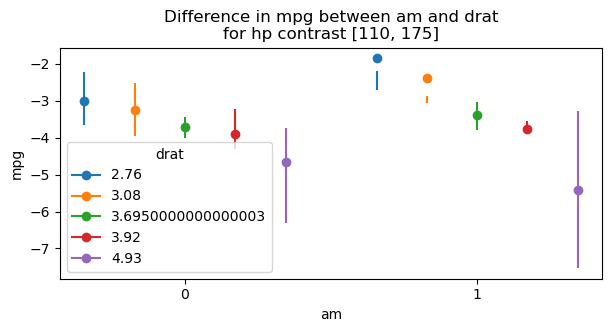

In [51]:
# user defined contrast for `hp`
# grid is determined for `am` and `drat`
# HDI does not include the mean contrast comparison...
fig, ax, comparisons_df, contrast_df, idata_new = plot_comparison(
    mt_model,
    mt_idata,
    contrast_predictor={"hp": [110, 175]},
    conditional=["am", "drat"]
)
fig.set_size_inches(7, 3)
plt.title("Difference in mpg between am and drat\nfor hp contrast [110, 175]");

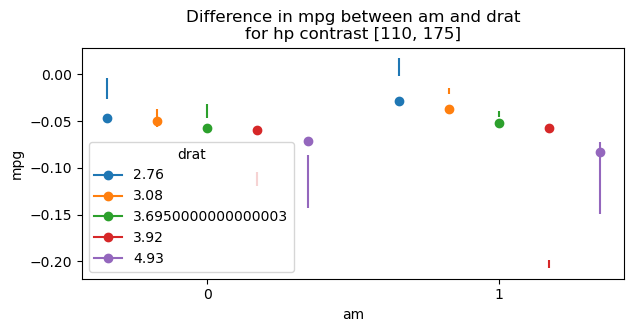

In [384]:
# HDI does not include the mean contrast comparison...
fig, ax, comparisons_df, contrast_df, idata_new = plot_comparison(
    mt_model,
    mt_idata,
    contrast_predictor="hp",
    conditional=["am", "drat"]
)
fig.set_size_inches(7, 3)
plt.title("Difference in mpg between am and drat\nfor hp contrast [110, 175]");

In [309]:
contrast_df

,estimate,hdi_3%,hdi_97%,term,contrast,am,drat
0,-0.046206,-0.003756,-0.026338,hp,"[146, 147]",0,2.760
1,-0.049976,-0.037245,-0.056671,hp,"[146, 147]",0,3.080
2,-0.057222,-0.047034,-0.031519,hp,"[146, 147]",0,3.695
3,-0.059873,-0.119706,-0.104732,hp,"[146, 147]",0,3.920
4,-0.071772,-0.142725,-0.086004,hp,"[146, 147]",0,4.930
5,-0.028507,-0.001350,0.017412,hp,"[146, 147]",1,2.760
6,-0.036580,-0.014789,-0.020630,hp,"[146, 147]",1,3.080
7,-0.052097,-0.038705,-0.045089,hp,"[146, 147]",1,3.695
8,-0.057774,-0.207495,-0.198384,hp,"[146, 147]",1,3.920
9,-0.083257,-0.148901,-0.072400,hp,"[146, 147]",1,4.930


### Palmer penguins

In [42]:
data = pd.read_csv("https://vincentarelbundock.github.io/Rdatasets/csv/palmerpenguins/penguins.csv", index_col=0)
data = data.dropna(axis=0, how="any")

In [43]:
data["species"] = pd.Categorical(data["species"])
data["island"] = pd.Categorical(data["island"])

In [44]:
penguin_model = bmb.Model(
    "body_mass_g ~ flipper_length_mm * species * bill_length_mm + island",
    data, family="gaussian"
)
penguin_idata = penguin_model.fit(draws=1000, target_accept=0.95, random_seed=1234)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [body_mass_g_sigma, Intercept, flipper_length_mm, species, flipper_length_mm:species, bill_length_mm, flipper_length_mm:bill_length_mm, species:bill_length_mm, flipper_length_mm:species:bill_length_mm, island]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 148 seconds.


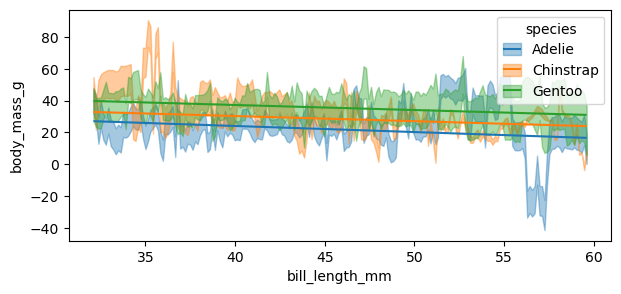

In [45]:
fig, ax, comparisons_df, contrast_df, idata_new = plot_comparison(
    model=penguin_model,
    idata=penguin_idata,
    contrast_predictor=["flipper_length_mm"],
    conditional=["bill_length_mm", "species"]
)
fig.set_size_inches(7, 3)

In [51]:
# HDI does not include the mean contrast comparison...
contrast_df

,estimate,hdi_3%,hdi_97%,bill_length_mm,species
0,27.068395,31.656234,47.725210,32.100000,Adelie
1,32.841295,36.742993,54.692950,32.100000,Chinstrap
2,39.724979,47.558343,27.397502,32.100000,Gentoo
3,27.015909,27.670022,43.843105,32.238191,Adelie
4,32.796798,21.727677,38.872678,32.238191,Chinstrap
...,...,...,...,...,...
595,24.030917,-3.644115,-0.958556,59.461809,Chinstrap
596,31.062888,44.355995,13.978242,59.461809,Gentoo
597,16.623552,0.342328,19.052322,59.600000,Adelie
598,23.986420,5.776226,8.969351,59.600000,Chinstrap


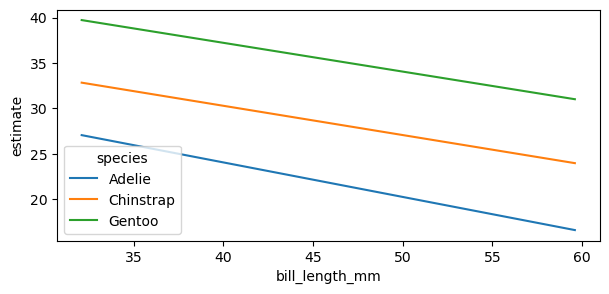

In [52]:
# should be???
plt.figure(figsize=(7, 3))
sns.lineplot(
    data=contrast_df,
    x="bill_length_mm",
    y="estimate",
    hue="species"
);

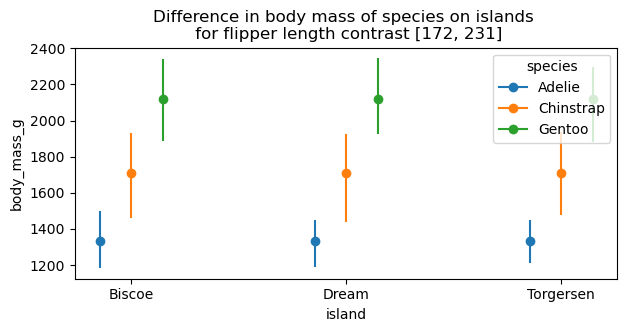

In [46]:
fig, ax, comparisons_df, contrast_df, idata  = plot_comparison(
    model=penguin_model,
    idata=penguin_idata,
    contrast_predictor={"flipper_length_mm": [172, 231]},
    conditional=["island", "species"]
)
fig.set_size_inches(7, 3)
plt.title("Difference in body mass of species on islands \n for flipper length contrast [172, 231]");

### Titanic

In [18]:
dat = pd.read_csv("https://vincentarelbundock.github.io/Rdatasets/csv/Stat2Data/Titanic.csv", index_col=0)

In [19]:
dat["PClass"] = dat["PClass"].str.replace("[st, nd, rd]", "", regex=True)
dat["PClass"] = dat["PClass"].str.replace("*", "0").astype(int)
dat["PClass"] = dat["PClass"].replace(0, np.nan)
dat["PClass"] = pd.Categorical(dat["PClass"], ordered=True)
dat["SexCode"] = pd.Categorical(dat["SexCode"], ordered=True)

In [20]:
dat = dat.dropna(axis=0, how="any")

In [21]:
titanic_model = bmb.Model(
    "Survived ~ PClass * SexCode * Age", 
    data=dat, 
    family="bernoulli"
)
titanic_idata = titanic_model.fit(draws=1000, target_accept=0.95, random_seed=1234)

Modeling the probability that Survived==1
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, PClass, SexCode, PClass:SexCode, Age, PClass:Age, SexCode:Age, PClass:SexCode:Age]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.


In [22]:
az.summary(titanic_idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,1.557,0.592,0.455,2.658,0.014,0.010,1898.0,2500.0,1.0
PClass[2.0],0.188,0.904,-1.491,1.885,0.022,0.016,1594.0,2342.0,1.0
PClass[3.0],-2.038,0.776,-3.495,-0.588,0.018,0.013,1795.0,2306.0,1.0
SexCode[1],1.090,1.238,-1.199,3.418,0.036,0.026,1201.0,1871.0,1.0
"PClass:SexCode[2.0, 1]",0.176,1.644,-2.901,3.206,0.047,0.033,1212.0,2053.0,1.0
"PClass:SexCode[3.0, 1]",-0.801,1.381,-3.434,1.792,0.040,0.028,1245.0,1785.0,1.0
Age,-0.056,0.015,-0.082,-0.027,0.000,0.000,1856.0,2411.0,1.0
PClass:Age[2.0],-0.090,0.033,-0.156,-0.030,0.001,0.001,1749.0,2195.0,1.0
PClass:Age[3.0],0.003,0.025,-0.044,0.049,0.001,0.000,1935.0,2673.0,1.0
SexCode:Age[1],0.069,0.032,0.010,0.128,0.001,0.001,1318.0,1865.0,1.0


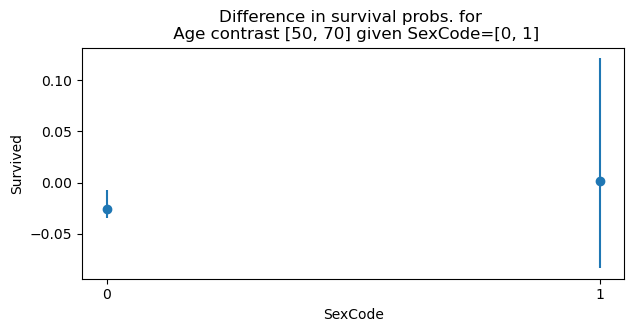

In [33]:
fig, ax, comparisons_df, contrast_df, idata = plot_comparison(
    model=titanic_model,
    idata=titanic_idata,
    contrast_predictor={"Age": [50, 70]},
    conditional="SexCode",
)
fig.set_size_inches(7, 3)
plt.title("Difference in survival probs. for \n Age contrast [50, 70] given SexCode=[0, 1]");

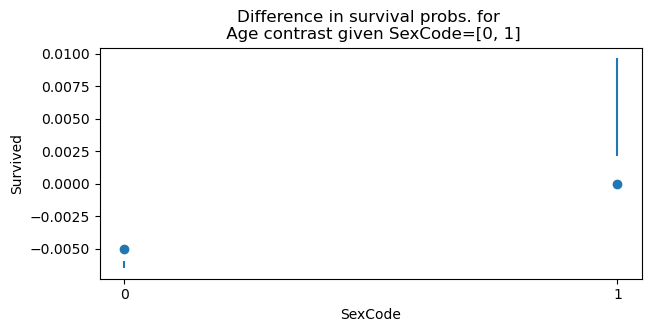

In [34]:
fig, ax, comparisons_df, contrast_df, idata = plot_comparison(
    model=titanic_model,
    idata=titanic_idata,
    contrast_predictor="Age",
    conditional="SexCode",
)
fig.set_size_inches(7, 3)
plt.title("Difference in survival probs. for \n Age contrast given SexCode=[0, 1]");

In [25]:
contrast_df

,estimate,hdi_3%,hdi_97%,term,contrast,SexCode
0,-0.005023,-0.006518,-0.005954,Age,"[29.897989417989418, 30.897989417989418]",0
1,-0.000058,0.002160,0.009651,Age,"[29.897989417989418, 30.897989417989418]",1


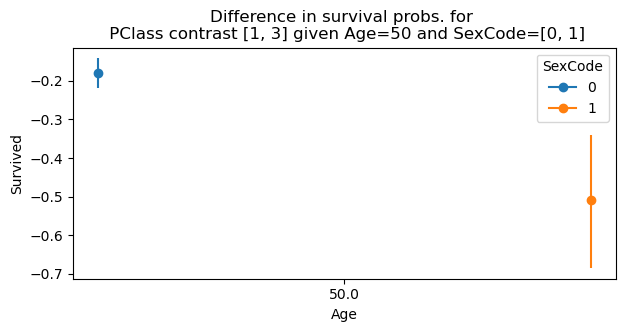

In [39]:
# user can also pass a dict into conditional to define the 
# values used for the conditional variables
fig, ax, comparisons_df, contrast_df, idata = plot_comparison(
    model=titanic_model,
    idata=titanic_idata,
    contrast_predictor={"PClass": [1, 3]},
    conditional={"Age": [50], "SexCode": [0, 1]}
)
fig.set_size_inches(7, 3)
plt.title("Difference in survival probs. for \n PClass contrast [1, 3] given Age=50 and SexCode=[0, 1]");

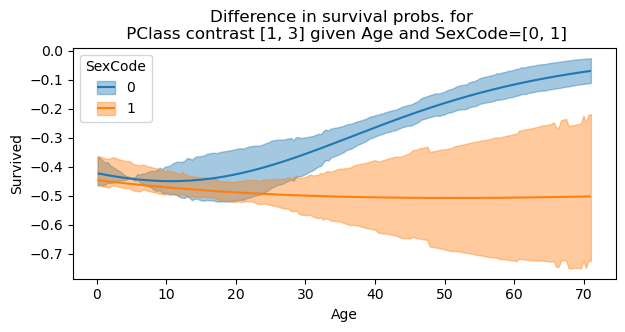

In [40]:
# user can also pass a dict into conditional to define the 
# values used for the conditional variables
fig, ax, comparisons_df, contrast_df, idata = plot_comparison(
    model=titanic_model,
    idata=titanic_idata,
    contrast_predictor={"PClass": [1, 3]},
    conditional=["Age", "SexCode"]
)
fig.set_size_inches(7, 3)
plt.title("Difference in survival probs. for \n PClass contrast [1, 3] given Age and SexCode=[0, 1]");

In [41]:
contrast_df

,estimate,hdi_3%,hdi_97%,term,contrast,Age,SexCode
0,-0.422889,-0.465363,-0.365073,PClass,"[1.0, 3.0]",0.170000,0
1,-0.446737,-0.461165,-0.363025,PClass,"[1.0, 3.0]",0.170000,1
2,-0.424556,-0.463182,-0.370336,PClass,"[1.0, 3.0]",0.525930,0
3,-0.447744,-0.463268,-0.364837,PClass,"[1.0, 3.0]",0.525930,1
4,-0.426182,-0.464886,-0.379725,PClass,"[1.0, 3.0]",0.881859,0
...,...,...,...,...,...,...,...
395,-0.502756,-0.750079,-0.246912,PClass,"[1.0, 3.0]",70.288141,1
396,-0.070087,-0.026109,-0.111842,PClass,"[1.0, 3.0]",70.644070,0
397,-0.502566,-0.725240,-0.220199,PClass,"[1.0, 3.0]",70.644070,1
398,-0.068890,-0.025093,-0.110175,PClass,"[1.0, 3.0]",71.000000,0


## Negative Binomial Model

In [418]:
# Load data, define and fit Bambi model
data = pd.read_stata("https://stats.idre.ucla.edu/stat/stata/dae/nb_data.dta")
data["prog"] = data["prog"].map({1: "General", 2: "Academic", 3: "Vocational"})

model_interaction = bmb.Model(
    "daysabs ~ 0 + prog + scale(math) + prog:scale(math)",
    data,
    family="negativebinomial"
)
idata_interaction = model_interaction.fit(
    draws=1000, target_accept=0.95, random_seed=1234, chains=4
)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [daysabs_alpha, prog, scale(math), prog:scale(math)]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


contrast_predictor: math
model covariates: {'main': dict_keys(['prog']), 'group': None, 'panel': None}


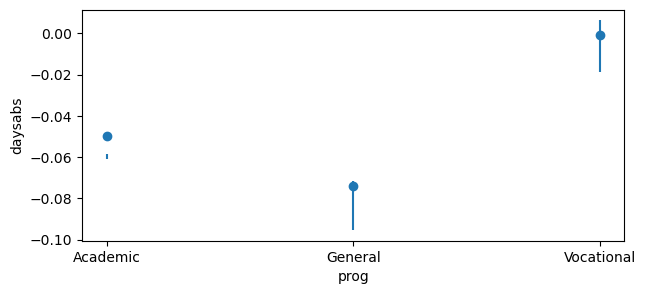

In [13]:
fig, ax, comparisons_df, contrast_df, idata = plot_comparison(
    model=model_interaction,
    idata=idata_interaction,
    contrast_predictor="math",
    conditional={"prog": ["General", "Academic", "Vocational"]},
)
fig.set_size_inches(7, 3)

contrast_predictor: {'prog': ['Academic', 'General']}
model covariates: {'main': 'math', 'group': None, 'panel': None}


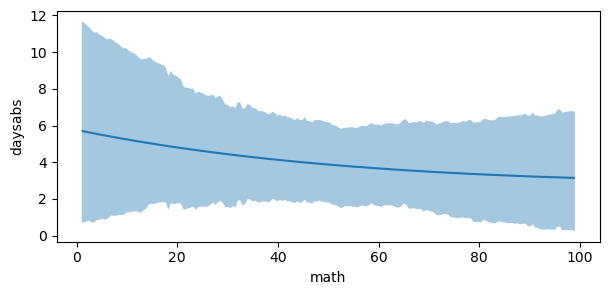

In [16]:
fig, ax, comparisons_df, contrast_df, idata = plot_comparison(
    model=model_interaction,
    idata=idata_interaction,
    contrast_predictor={"prog": ["Academic", "General"]},
    conditional="math",
)
fig.set_size_inches(7, 3)

In [17]:
contrast_df

,estimate,hdi_3%,hdi_97%,term,contrast,math
0,5.705757,0.694269,11.687646,prog,"[Academic, General]",1.000000
1,5.678390,0.729327,11.589513,prog,"[Academic, General]",1.492462
2,5.651256,0.765818,11.482617,prog,"[Academic, General]",1.984925
3,5.624354,0.805502,11.371551,prog,"[Academic, General]",2.477387
4,5.597680,0.718516,11.194215,prog,"[Academic, General]",2.969849
...,...,...,...,...,...,...
195,3.159759,0.300138,6.751941,prog,"[Academic, General]",97.030151
196,3.155537,0.289272,6.754177,prog,"[Academic, General]",97.522614
197,3.151369,0.296382,6.781164,prog,"[Academic, General]",98.015076
198,3.147253,0.290754,6.790572,prog,"[Academic, General]",98.507538


In [15]:
# more than two factor levels for the contrast predictor: need to add support
fig, ax, comparisons_df, contrast_df, idata = plot_comparison(
    model=model_interaction,
    idata=idata_interaction,
    contrast_predictor="prog",
    conditional="math",
)
fig.set_size_inches(7, 3)

contrast_predictor: prog
model covariates: {'main': 'math', 'group': None, 'panel': None}


ValueError: Contrast must have 2 values to compute estimate.

### Zero Inflated Poisson

In [422]:
fish_data = pd.read_stata("http://www.stata-press.com/data/r11/fish.dta")
cols = ["count", "livebait", "camper", "persons", "child"]
fish_data = fish_data[cols]

# convert livebait and camper to categorical
fish_data["livebait"] = fish_data["livebait"].astype("category")
fish_data["camper"] = fish_data["camper"].astype("category")
#fish_data["persons"] = pd.Categorical(fish_data["persons"], ordered=True)
#fish_data["child"] = pd.Categorical(fish_data["child"], ordered=True)

In [423]:
fish_data.describe().T

,count,mean,std,min,25%,50%,75%,max
count,250.0,3.296,11.635028,0.0,0.0,0.0,2.0,149.0
persons,250.0,2.528,1.112730,1.0,2.0,2.0,4.0,4.0
child,250.0,0.684,0.850315,0.0,0.0,0.0,1.0,3.0


In [ ]:
likelihood = bmb.Likelihood("ZeroInflatedPoisson", params=["mu", "psi"], parent="mu")
links = {"mu": "log", "psi": "logit"}
zip_family = bmb.Family("zip", likelihood, links)
zip_family

In [425]:
priors = {"psi": bmb.Prior("Beta", alpha=3, beta=3)}
fish_model = bmb.Model(
    "count ~ livebait + camper + persons + child", 
    fish_data, 
    priors=priors,
    family=zip_family
)

In [426]:
fish_idata = fish_model.fit(
    draws=1000, target_accept=0.95, random_seed=1234, chains=4
)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [count_psi, Intercept, livebait, camper, persons, child]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


In [427]:
az.summary(fish_idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-2.556,0.288,-3.093,-2.024,0.005,0.004,3360.0,2685.0,1.0
livebait[1.0],1.732,0.242,1.275,2.172,0.004,0.003,3830.0,2381.0,1.0
camper[1.0],0.674,0.095,0.492,0.845,0.001,0.001,4447.0,2735.0,1.0
persons,0.875,0.044,0.796,0.960,0.001,0.001,3528.0,2819.0,1.0
child,-1.394,0.094,-1.581,-1.226,0.002,0.001,3046.0,2921.0,1.0
count_psi,0.614,0.045,0.530,0.695,0.001,0.001,3895.0,2825.0,1.0


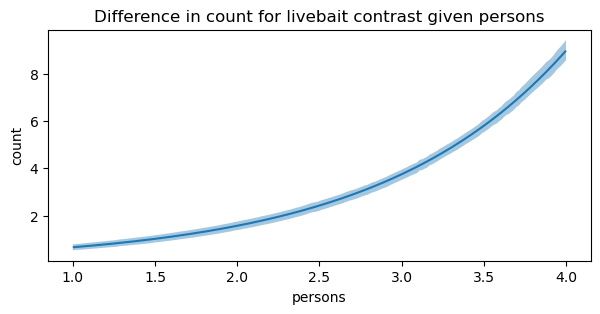

In [429]:
fig, ax, comparisons_df, contrast_df, idata = plot_comparison(
    model=fish_model,
    idata=fish_idata,
    contrast_predictor="livebait",
    conditional=["persons"]
) 
fig.set_size_inches(7, 3)
plt.title("Difference in count for livebait contrast given persons");

In [430]:
contrast_df

,estimate,hdi_3%,hdi_97%,term,contrast,persons
0,0.656590,0.531371,0.782847,livebait,"[0.0, 1.0]",1.000000
1,0.665252,0.539250,0.792428,livebait,"[0.0, 1.0]",1.015075
2,0.674029,0.546448,0.801334,livebait,"[0.0, 1.0]",1.030151
3,0.682921,0.553074,0.809918,livebait,"[0.0, 1.0]",1.045226
4,0.691932,0.561033,0.820228,livebait,"[0.0, 1.0]",1.060302
...,...,...,...,...,...,...
195,8.527929,8.146434,8.946129,livebait,"[0.0, 1.0]",3.939698
196,8.641176,8.252712,9.068106,livebait,"[0.0, 1.0]",3.954774
197,8.755931,8.349079,9.176463,livebait,"[0.0, 1.0]",3.969849
198,8.872211,8.462268,9.301371,livebait,"[0.0, 1.0]",3.984925
